# OpenCL Difftest Results

Import prereqs and connect to results database:

In [12]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import datetime
from labm8 import humanize

from collections import OrderedDict
from matplotlib.ticker import FuncFormatter
from collections import OrderedDict
from labm8 import fs, viz

def cache_time(path):
    modified = datetime.datetime.fromtimestamp(os.path.getmtime(path))
    diff = datetime.datetime.now() - modified
    return humanize.Duration(diff) + " ago ({})".format(modified)

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

import dsmith
import dsmith.opencl.db
from dsmith.opencl.db import *

!mkdir -pv .cache .tex

# initialize db
dsmith.langs.mklang("opencl")

mkdir: created directory '.tex'


opencl

## Overview

Summary of testing results:

In [2]:
# !rm -fv .cache/overview.csv

In [3]:
def get_device_overview(s: session_t):
    r = s.execute(f"""
SELECT	device,
		optimizations,
        devtype,
        clsmith_results,
        clsmith_time,
        dsmith_results,
        dsmith_time
FROM (
	SELECT	testbed_id,
			device,
			optimizations,
            devtype,
			COUNT(*) AS clsmith_results,
            ROUND(SUM(total_time) / 3600, 1) AS clsmith_time
	FROM {Result.__tablename__} results
	INNER JOIN {Testcase.__tablename__} testcases ON results.testcase_id = testcases.id
	INNER JOIN {Testbed.__tablename__} testbeds on results.testbed_id = testbeds.id
	INNER JOIN {Platform.__tablename__} platforms ON testbeds.platform_id = platforms.id
	INNER JOIN {ResultMeta.__tablename__} results_metas ON results.id = results_metas.id
	WHERE harness = {Harnesses.CL_LAUNCHER}
	GROUP BY testbed_id, device, optimizations, devtype
) clsmith
LEFT JOIN (
	SELECT	testbed_id,
			COUNT(*) AS dsmith_results,
            ROUND(SUM(total_time) / 3600, 1) AS dsmith_time
	FROM {Result.__tablename__} results
	INNER JOIN {Testcase.__tablename__} testcases ON results.testcase_id = testcases.id
	INNER JOIN {Testbed.__tablename__} testbeds on results.testbed_id = testbeds.id
	INNER JOIN {Platform.__tablename__} platforms ON testbeds.platform_id = platforms.id
	INNER JOIN {ResultMeta.__tablename__} results_metas ON results.id = results_metas.id
	WHERE harness = {Harnesses.CLDRIVE}
	GROUP BY testbed_id
) dsmith ON clsmith.testbed_id = dsmith.testbed_id
ORDER BY devtype, device, optimizations
""").fetchall()

    table = pd.DataFrame([{
            "Device": Platform(device=row[0]).device_name,
            "num": Platform(device=row[0]).num,
            "±": Testbed(optimizations=row[1]).plus_minus,
            "Device type": Platform(devtype=row[2]).devtype_name,
            "CLSmith results": row[3],
            "CLSmith time (hrs)": row[4],
            "Dsmith results": row[5],
            "Dsmith time (hrs)": row[6],
        } for row in r],
        columns=["Device", "num", "±", "Device type",
                 "CLSmith results", "CLSmith time (hrs)",
                 "Dsmith results", "Dsmith time (hrs)"])
    return table


def get_overview_table():
    cachepath = ".cache/overview.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={
            "CLSmith time (hrs)": np.float32, "Dsmith time (hrs)": np.float32,
            "CLSmith results": np.int32, "Dsmith results": np.int32,
        })
    else:
        rows = []
        with Session() as s:
            table = get_device_overview(s).sort_values(["num", "±"])
        table.to_csv(cachepath, index=False)
        return get_overview_table()


overview_table = get_overview_table()
overview_table

cached 58 minutes ago (2017-10-18 23:44:13.083304)


,Device,num,±,Device type,CLSmith results,CLSmith time (hrs),Dsmith results,Dsmith time (hrs)
0,GeForce GTX 1080,1,+,GPU,19998,66.800003,116429,97.500000
1,GeForce GTX 1080,1,-,GPU,19992,62.099998,119806,94.900002
2,GeForce GTX 780,2,+,GPU,20994,57.000000,152567,85.800003
3,GeForce GTX 780,2,-,GPU,20996,55.200001,152567,81.500000
4,Intel HD Haswell GT2,3,+,GPU,15371,118.300003,152569,53.299999
5,Intel HD Haswell GT2,3,-,GPU,8014,61.000000,152571,52.799999
6,Intel E5-2620 v4,4,+,CPU,20994,52.900002,140548,59.299999
7,Intel E5-2620 v4,4,-,CPU,20987,57.299999,140602,63.799999
8,Intel E5-2650 v2,5,+,CPU,20997,67.099998,152567,82.599998
9,Intel E5-2650 v2,5,-,CPU,20998,56.099998,152571,83.500000


In [4]:
dsmith_total_hours = sum(overview_table["Dsmith time (hrs)"])
clsmith_total_hours = sum(overview_table["CLSmith time (hrs)"])
print(f"DeepSmith total testing time: {dsmith_total_hours:.1f} hours")
print(f"CLSmith total testing time: {clsmith_total_hours:.1f} hours")

DeepSmith total testing time: 1542.9 hours
CLSmith total testing time: 1617.8 hours


## Schedule

Calculate schedule of remaining jobs which must be ran to meet a minimum time limit.

In [5]:
MIN_TIME_LIMIT = min(min(overview_table["Dsmith time (hrs)"]),
                     min(overview_table["CLSmith time (hrs)"]))
print(f"The minimum hours on a device is {MIN_TIME_LIMIT:.1f} hrs")

The minimum hours on a device is 48.2 hrs


In [6]:
TIME_LIMIT = 96
schedule = []
for _, row in overview_table.iterrows():
    for source in ["Dsmith", "CLSmith"]:
        if row[f"{source} time (hrs)"] < TIME_LIMIT:
            d = OrderedDict()
            d["Device"] = row["Device"]
            d["num"] = row["num"]
            d["±"] = row["±"]
            d["Generator"] = source
            d["Remaining time"] = (TIME_LIMIT - row[f"{source} time (hrs)"])
            d["Remaining time (hrs)"] = "{:.1f}h".format((TIME_LIMIT - row[f"{source} time (hrs)"]))
            schedule.append(d)

schedule = pd.DataFrame(schedule).sort_values("Remaining time", ascending=False) if len(schedule) else "nothing to do"
schedule

,Device,num,±,Generator,Remaining time,Remaining time (hrs)
19,Intel i5-4570,6,+,CLSmith,47.799999,47.8h
8,Intel HD Haswell GT2,3,-,Dsmith,43.200001,43.2h
11,Intel E5-2620 v4,4,+,CLSmith,43.099998,43.1h
7,Intel HD Haswell GT2,3,+,Dsmith,42.700001,42.7h
28,POCL (Intel E5-2620),8,-,CLSmith,42.500000,42.5h
32,ComputeAorta (Intel E5-2620),9,-,CLSmith,42.299999,42.3h
21,Intel i5-4570,6,-,CLSmith,41.200001,41.2h
6,GeForce GTX 780,2,-,CLSmith,40.799999,40.8h
17,Intel E5-2650 v2,5,-,CLSmith,39.900002,39.9h
4,GeForce GTX 780,2,+,CLSmith,39.000000,39.0h


## Testing Time

Plot total testing time of each configuration.

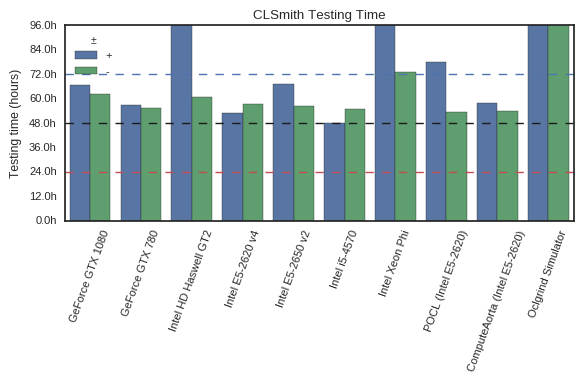

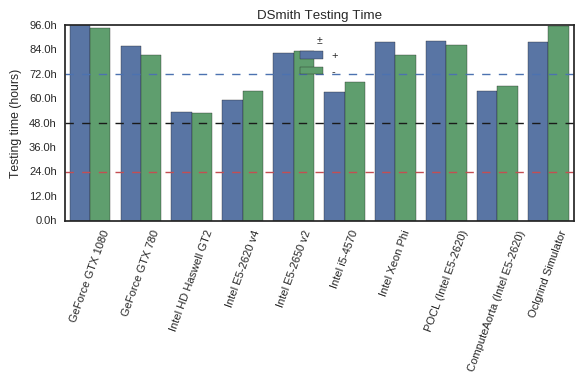

In [7]:
plt.style.use(["seaborn-white", "seaborn-paper"])

def plot_testing_time(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=70)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.set_ylim((0, 96))
    plt.yticks(np.arange(0, 100, 12))
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}h".format(x)))
    ax.set_ylabel("Testing time (hours)")
    plt.title(title)

    plt.axhline(y=24, color="r", lw=1, linestyle="--")
    plt.axhline(y=48, color="k", lw=1, linestyle="--")
    plt.axhline(y=72, color="b", lw=1, linestyle="--")

    viz.finalise(figsize=(6, 4))

plot_testing_time(overview_table, "CLSmith time (hrs)", "CLSmith Testing Time")
plot_testing_time(overview_table, "Dsmith time (hrs)", "DSmith Testing Time")

## Number of Results

Plot the number of results for each configuration.

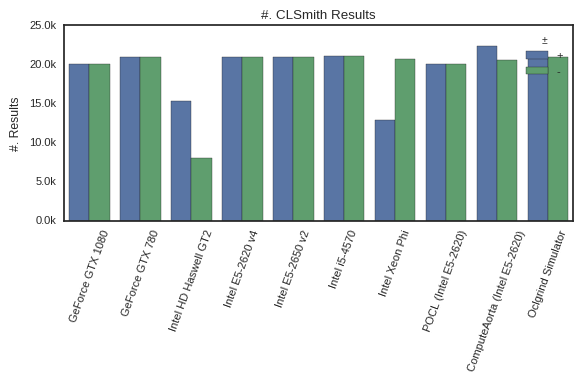

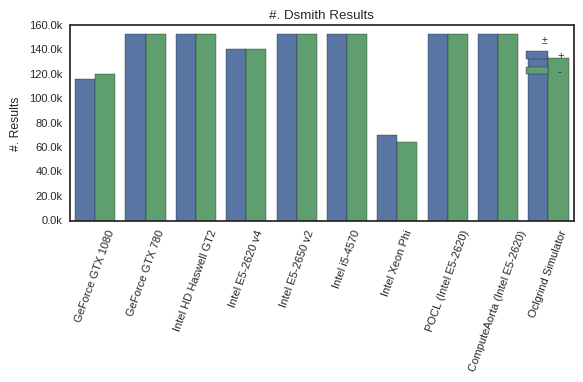

In [8]:
plt.style.use(["seaborn-white", "seaborn-paper"])

def plot_num_results(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=70)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}k".format(x / 1000)))
    ax.set_ylabel("#. Results")
    plt.title(title)

    viz.finalise(figsize=(6, 4))

plot_num_results(overview_table, "CLSmith results", "#. CLSmith Results")
plot_num_results(overview_table, "Dsmith results", "#. Dsmith Results")

## Testbeds

In [14]:
total_time = 0

def get_platform_stats(s, testbed: Testbed):
    global total_time

    # TODO: reduction times
    testing_time = sum(overview_table.loc[overview_table["Device"] == testbed.platform.device_name]["Dsmith time (hrs)"].values)

    total_time += testing_time
    return testing_time


def get_row(s, testbed: Testbed):
    d = OrderedDict()
    d["#."] = dsmith.unformat(str(testbed))
    d["Platform"] = testbed.platform.platform_name
    d["Device"] = testbed.platform.device_name
    d["Driver"] = testbed.platform.driver_name
    d["OpenCL"] = testbed.platform.opencl
    d["Operating system"] = testbed.platform.host_name
    d["Device type"] = testbed.platform.devtype_name
    d["Open Source?"] = "Yes"
    runtime = get_platform_stats(s, testbed)
    d["Testing time"] = "{:.0f} hours".format(round(runtime))
    return d


def get_testbeds_table():
    rows = []
    with Session(commit=False) as s:
        rows += [get_row(s, testbed) for testbed in s.query(Testbed)]
    return pd.DataFrame(rows)

testbeds_table = get_testbeds_table()

with open(os.path.expanduser(".tex/platforms.tex"), "w") as outfile:
    print(f"""\
\\begin{{tabular}}{{ cllllllL{{1cm}} | rR{{1.4cm}} }}
\\toprule
\\textbf{{\\#. }} & \\textbf{{Platform}} & \\textbf{{Device}} & \\textbf{{Driver}} & \\textbf{{OpenCL}} & 
\\textbf{{Operating system}} & \\textbf{{Device Type}} & \\textbf{{Open Source?}} & \\textbf{{Testing time}} & \\textbf{{Bug Reports Submitted}} \\\\
\\midrule""", file=outfile)
    for _, row in testbeds_table.iterrows():
        print(" & ".join([str(x) for x in row]), "\\\\", file=outfile)
    print(f"""
\\bottomrule
\\end{{tabular}}
""", file=outfile)

testbeds_table

,#.,Platform,Device,Driver,OpenCL,Operating system,Device type,Open Source?,Testing time
0,1-,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 x64,GPU,Yes,192 hours
1,1+,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 x64,GPU,Yes,192 hours
2,4-,Intel OpenCL,Intel E5-2620 v4,1.2.0.25,2.0,Ubuntu 16.04 x64,CPU,Yes,123 hours
3,4+,Intel OpenCL,Intel E5-2620 v4,1.2.0.25,2.0,Ubuntu 16.04 x64,CPU,Yes,123 hours
4,6-,Intel OpenCL,Intel i5-4570,1.2.0.25,1.2,Ubuntu 16.04 x64,CPU,Yes,131 hours
5,6+,Intel OpenCL,Intel i5-4570,1.2.0.25,1.2,Ubuntu 16.04 x64,CPU,Yes,131 hours
6,10-,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 x64,Emulator,Yes,183 hours
7,10+,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 x64,Emulator,Yes,183 hours
8,8-,POCL,POCL (Intel E5-2620),0.14,2.0,Ubuntu 16.04 x64,CPU,Yes,175 hours
9,8+,POCL,POCL (Intel E5-2620),0.14,2.0,Ubuntu 16.04 x64,CPU,Yes,175 hours


In [18]:
print(f"Total testing time: {total_time:.1f} hours")

Total testing time: 3470.6 hours


In [19]:
# TODO: %run mkmegatable.ipy

## Runtimes

In [20]:
# delete cached result:
!rm -fv .cache/runtimes.csv

In [ ]:
import math

def get_runtimes_table():
    """ get runtimes of test case generation, execution, and reduction. cache results to file """
    cachepath = ".cache/runtimes.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={"Runtime (s)": np.float32})
    else:
        with open(cachepath, "w") as outfile:
            print("Source", "Name", "Runtime (s)", sep=',', file=outfile)
            with Session(commit=False) as s:
                for tables in [CLSMITH_TABLES, CLGEN_TABLES]:
                    q = s.query(tables.results.runtime,
                                tables.programs.runtime)\
                        .join(tables.meta)\
                        .join(tables.testcases)\
                        .join(tables.programs)\
                        .filter(tables.meta.cumtime < TIME_LIMIT)

                    name = "DeepSmith" if tables.name == "CLgen" else tables.name
                    for runtime, generation_time in q:
                        if generation_time < TIMEOUT:
                            print(name, "Generation", generation_time, sep=',', file=outfile)
                        if runtime < TIMEOUT:
                            print(name, "Execution", runtime, sep=',', file=outfile)

            return get_runtimes_table()

runtimes_table = get_runtimes_table()
print("loaded", len(runtimes_table), "runtimes")

In [ ]:
def avg_time(source, name):
    vals = runtimes_table[(runtimes_table["Source"] == source) & (runtimes_table["Name"] == name)]["Runtime (s)"].values
    vals = vals[~np.isnan(vals)]   # FIXME: NaN in DeepSmith Execution time?
    return vals.mean()
    
clsmith_avgs = np.array([
    avg_time("CLSmith", "Generation"),
    avg_time("CLSmith", "Execution"),
])
clgen_avgs = np.array([
    avg_time("DeepSmith", "Generation"),
    avg_time("DeepSmith", "Execution"),
])

total_speedup = (clsmith_avgs[0] + clsmith_avgs[1]) / (clgen_avgs[0] + clgen_avgs[1])
print(f"Total speedup is {total_speedup:.2f}x")

speedups = clsmith_avgs / clgen_avgs
generation_speedup, execution_speedup = speedups
print(f"DeepSmith generation is {generation_speedup:.2f}x faster than CLSmith")
print(f"DeepSmith execution is {execution_speedup:.2f}x faster than CLSmith")

In [ ]:
sns.set(style="ticks")

def plot_runtimes(runtimes_table, *args, **kwargs):
    # Plot
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=runtimes_table,
        width=.85, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution"])

    
    # Y axis
    ax.set_yscale("log", nonposy='clip')

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='lower right', ncol=2)
    ax.get_legend().draw_frame(True)
    
    # Border
    sns.despine(ax=ax)

    viz.finalise(*args, **kwargs)


plot_runtimes(runtimes_table, figsize=(4, 2.7))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_runtimes(runtimes_table, fs.path("~/docs/paper-project_b/build/img/runtimes.pdf"), figsize=(4, 2.7))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/runtimes.pdf" && git push

## Comparison to CLSmith

In [ ]:
!rm -fv .cache/kernel-sizes.csv

In [ ]:
def get_kernel_sizes(s: session_t, tables: Tableset, outfile):
    q = s.query(tables.results.id, tables.programs.size)\
            .join(tables.meta)\
            .join(tables.testcases)\
            .join(tables.programs)\
            .filter(tables.meta.cumtime < TIME_LIMIT)
    name = "DeepSmith" if tables.name == "CLgen" else tables.name
    for classification, size in q:
        print("Kernel", size, name, sep=",", file=outfile)

def get_kernel_sizes_table():
    cachepath = ".cache/kernel-sizes.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={"Size": np.float32})
    else:
        with open(cachepath, "w") as outfile:
            print("Classification", "Size", "Source", sep=",", file=outfile)
            with Session(commit=False) as s:
                for tables in [CLSMITH_TABLES, CLGEN_TABLES]:
                    get_kernel_sizes(s, tables, outfile)

        return get_kernel_sizes_table()

kernel_sizes_table = get_kernel_sizes_table()
print("loaded", len(kernel_sizes_table), "line counts")

In [ ]:
from matplotlib import gridspec
sns.set(style="ticks")

def plot_runtimes(runtimes_table, *args, **kwargs):
    # Plot
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=runtimes_table,
        width=.85, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution"])

    plt.title("a", color="white")
    
    # Y axis
    ax.set_yscale("log", nonposy='clip')

    # X axis
    plt.xlabel("\n(a)")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='lower right', ncol=2)
    ax.legend().set_visible(False)
    
    # Border
    sns.despine(ax=ax)


def plot_kernel_sizes(table, *args, **kwargs):
    sns.set(style="ticks")
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Classification", y="Size", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette)#, order=["bc", "bto", "bf", "c", "w"])

    plt.title("a", color="white")
    
    # Y axis
    plt.ylabel("Kernel Size (bytes)")
    ax.set_yscale("log", nonposy='clip')

    # X axis
    plt.xlabel("\n(b)")
    plt.xticks([0], ['abc'], color='white')
    
    # Legend
    ax.legend().set_visible(False)
    
    # Border
    sns.despine(ax=ax)

def plot_both(*args, **kwargs):
    fig = plt.figure() 
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
    ax0 = plt.subplot(gs[0])

    plot_runtimes(runtimes_table)

    ax1 = plt.subplot(gs[1])
    plot_kernel_sizes(kernel_sizes_table)

    # Legend
    plt.legend(loc=(-2.85, 1.06), ncol=2)
    ax1.get_legend().set_title("")
    ax1.get_legend().draw_frame(True)

    viz.finalise(*args, **kwargs, figsize=(4, 3), tight_layout=False)

plot_both()

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_both(fs.path("~/docs/paper-project_b/build/img/vs-clsmith.pdf"))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/vs-clsmith.pdf" && git push

## Kernel Sizes

In [ ]:
def get_kernel_sizes(s: session_t, tables: Tableset, outfile):
    q = s.query(tables.classifications.classification, tables.programs.size)\
            .join(tables.results)\
            .join(tables.meta)\
            .join(tables.testcases)\
            .join(tables.programs)\
            .filter(tables.meta.cumtime < TIME_LIMIT)
    name = "DeepSmith" if tables.name == "CLgen" else tables.name
    for classification, size in q:
        print(CLASSIFICATIONS[classification], size, name, sep=",", file=outfile)

def get_kernel_sizes_table():
    cachepath = ".cache/kernel-sizes.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={"Size": np.float32})
    else:
        with open(cachepath, "w") as outfile:
            print("Classification", "Size", "Source", sep=",", file=outfile)
            with Session(commit=False) as s:
                for tables in [CLSMITH_TABLES, CLGEN_TABLES]:
                    get_kernel_sizes(s, tables, outfile)

        return get_kernel_sizes_table()

kernel_sizes_table = get_kernel_sizes_table()
print("loaded", len(kernel_sizes_table), "line counts")

In [ ]:
def plot_kernel_sizes(table, *args, **kwargs):
    sns.set(style="ticks")
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Classification", y="Size", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["bc", "bto", "bf", "c", "w"])

    # Y axis
    plt.ylabel("Kernel Size (chars)")
    ax.set_yscale("log", nonposy='clip')
    # plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper right', ncol=2)
    ax.get_legend().draw_frame(True)
    
    # Border
    sns.despine(ax=ax)
    
    viz.finalise(*args, **kwargs)
    
figsize = (4, 2.7)
plot_kernel_sizes(kernel_sizes_table, figsize=figsize)

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_kernel_sizes(kernel_sizes_table, fs.path("~/docs/paper-project_b/build/img/kernel-sizes.pdf"), figsize=figsize)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/kernel-sizes.pdf" && git push

## Compiler Crashes

In [ ]:
!rm -fv .cache/compiler-crashes.csv

In [ ]:
def get_bcs(s, tables, outfile):
    q = s.query(tables.meta.cumtime / 3600, TestbedConfig.num)\
        .join(tables.results)\
        .join(TestbedConfig, TestbedConfig.id == tables.results.testbed_id)\
        .filter(tables.results.outcome == OUTCOMES_TO_INT["bc"],
                tables.meta.cumtime < 48 * 3600,
                tables.results.testbed_id != 13)\
        .order_by(tables.meta.cumtime)
    for cumtime, num in q:
        print(num, cumtime, tables.name, sep=",", file=outfile)

def get_bcs_table():
    cachepath = ".cache/compiler-crashes.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={"Timestamp": np.float32})
    else:
        with open(cachepath, "w") as outfile:
            print("Configuration", "Timestamp", "Source", sep=",", file=outfile)
            with Session(commit=False) as s:
                get_bcs(s, CLSMITH_TABLES, outfile)
                get_bcs(s, CLGEN_TABLES, outfile)
            return get_bcs_table()

bcs_table = get_bcs_table()

## Total time

In [ ]:
def get_totaltimes():
    
    def _t(s, results_table, programs_table, reductions_table):
        generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
        runtime = results_table.runtime
        reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)
        total_time = generation_time + runtime + reduction_time

        q = s.query(total_time)\
            .outerjoin(programs_table)\
            .outerjoin(reductions_table)\
            .filter(results_table.classification != None)\
            .order_by(results_table.date)

        times = np.array([row[0] / 3600 for row in q]).cumsum()
        return times
    
    with Session(commit=False) as s:
        clsmith_times = _t(s, CLSmithResult, CLSmithProgram, CLSmithReduction)
        clgen_times = _t(s, CLgenResult, CLgenProgram, CLgenReduction)

    return clsmith_times, clgen_times

clsmith_times, clgen_times = get_totaltimes()

In [ ]:
def plot_total_tests(clsmith_times, clgen_times, *args, **kwargs):
    
    def thousands(x, pos):
        return "{:.0f}k".format(x / 1000)
    
    ax = plt.gca()
    ax.plot(clsmith_times, range(len(clsmith_times)), label="CLSmith")
    ax.plot(clgen_times, range(len(clgen_times)), label="CLgen")

    ax.set_xlabel("Testing time (hours)")
    ax.set_ylabel("Completed Test cases")
    
    # X axis
    ax.set_xlim((0, 48))
    
    # Y axis
    formatter = FuncFormatter(thousands)
    ax.set_ylim((0, 100000))
    ax.yaxis.set_major_formatter(formatter)
    
    ax.legend()
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
        
    viz.finalise(*args, **kwargs)

plot_total_tests(clsmith_times, clgen_times, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_total_tests(clsmith_times, clgen_times, fs.path("~/docs/paper-project_b/build/img/total-tests.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/total-tests.pdf" && git push

In [ ]:
def get_outcomes_df_for_source(s: session_t, tables: Tableset, time_limit: int):
    q = s.execute(f"""
SELECT num, device, optimizations, outcome, COUNT(*)
FROM {tables.results.__tablename__} results
INNER JOIN {tables.meta.__tablename__} meta ON results.id = meta.id
INNER JOIN {tables.testcases.__tablename__} testcases ON results.testcase_id = testcases.id
INNER JOIN {tables.params.__tablename__} params ON testcases.params_id = params.id
INNER JOIN Configurations ON results.testbed_id = Configurations.id
INNER JOIN Testbeds ON results.testbed_id = Testbeds.id
WHERE cumtime < {time_limit}
GROUP BY num, device, outcome, optimizations
ORDER BY num, outcome, optimizations;
""")
    return pd.DataFrame([[tables.name] + list(row) for row in q],
                        columns=["source", "num", "device", "optimizations", "outcome", "count"])


def get_outcomes_df(s: session_t, time_limit: int):
    clsmith_table = get_outcomes_df_for_source(s, CLSMITH_TABLES, time_limit)
    clgen_table = get_outcomes_df_for_source(s, CLGEN_TABLES, time_limit)
    return pd.concat((clsmith_table, clgen_table))


def get_classifications_df_for_source(s: session_t, tables: Tableset, time_limit: int):
    q = s.execute(f"""
SELECT num, device, optimizations, classification, COUNT(*)
FROM {tables.results.__tablename__} results
INNER JOIN {tables.classifications} classifications ON results.id = classifications.id
INNER JOIN {tables.meta.__tablename__} meta ON results.id = meta.id
INNER JOIN {tables.testcases.__tablename__} testcases ON results.testcase_id = testcases.id
INNER JOIN {tables.params.__tablename__} params ON testcases.params_id = params.id
INNER JOIN Configurations ON results.testbed_id = Configurations.id
INNER JOIN Testbeds ON results.testbed_id = Testbeds.id
WHERE cumtime < {time_limit}
GROUP BY num, device, classification, optimizations
ORDER BY num, classification, optimizations;
""")
    return pd.DataFrame([[tables.name] + list(row) for row in q],
                        columns=["source", "num", "device", "optimizations", "classification", "count"])


def get_classifications_df(s: session_t, time_limit: int):
    clsmith_table = get_classifications_df_for_source(s, CLSMITH_TABLES, time_limit)
    clgen_table = get_classifications_df_for_source(s, CLGEN_TABLES, time_limit)
    return pd.concat((clsmith_table, clgen_table))